In [21]:
#!rm -rf 

In [22]:
!pip install wandb
!wandb --version
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.1 MB/s eta 0:00:0000:010:01
wandb, version 0.15.12


In [24]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import shutil
from shutil import copyfile
import matplotlib.pyplot as plt
from matplotlib import animation, rc
rc('animation', html='jshtml')
from PIL import Image
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5016.7/8062.4 GB disk)


In [25]:
dir0='105_classes_pins_dataset'
names0=os.listdir(dir0)
class_names=names0
print(class_names)
N=list(range(len(class_names)))
normal_mapping=dict(zip(class_names,N)) 
reverse_mapping=dict(zip(N,class_names))   

['pins_Alex Lawther', 'pins_Logan Lerman', 'pins_Maria Pedraza', 'pins_Anthony Mackie', 'pins_Bobby Morley', 'pins_Chris Evans', 'pins_Chris Pratt', 'pins_Mark Zuckerberg', 'pins_Anne Hathaway', 'pins_Emilia Clarke', 'pins_Cristiano Ronaldo', 'pins_Josh Radnor', 'pins_Henry Cavil', 'pins_Zoe Saldana', 'pins_ellen page', 'pins_Gwyneth Paltrow', 'pins_Natalie Dormer', 'pins_barbara palvin', 'pins_Krysten Ritter', 'pins_elon musk', 'pins_Leonardo DiCaprio', 'pins_Bill Gates', 'pins_elizabeth olsen', 'pins_Megan Fox', 'pins_Taylor Swift', 'pins_Tom Hiddleston', 'pins_Jeremy Renner', 'pins_melissa fumero', 'pins_Robert Downey Jr', 'pins_amber heard', 'pins_Jake Mcdorman', 'pins_Robert De Niro', 'pins_grant gustin', 'pins_Jennifer Lawrence', 'pins_Eliza Taylor', 'pins_scarlett johansson', 'pins_Marie Avgeropoulos', 'pins_Brenton Thwaites', 'pins_Adriana Lima', 'pins_Amanda Crew', 'pins_Hugh Jackman', 'pins_Katherine Langford', 'pins_camila mendes', 'pins_Selena Gomez', 'pins_Avril Lavigne', 

In [26]:
!mkdir datasets

mkdir: cannot create directory ‘datasets’: File exists


In [27]:
import zipfile

def create_zip(source_folder, destination_zip):
    with zipfile.ZipFile(destination_zip, 'w', zipfile.ZIP_DEFLATED) as zip_ref:
        for root, dirs, files in os.walk(source_folder):
            for file in files:
                file_path = os.path.join(root, file)
                zip_ref.write(file_path, arcname=os.path.relpath(file_path, source_folder))

def extract_zip(zip_file, destination_folder):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(destination_folder)

source_folder = 'pins-face-detection-w-mtcnn-for-yolo/datasets'
destination_zip = 'folder.zip'
destination_folder = 'datasets'

create_zip(source_folder, destination_zip)
extract_zip(destination_zip, destination_folder)      

In [28]:
import yaml

data_yaml = dict(
    train ='train',
    val ='valid',
    test='test',
    nc =len(names0),
    names =names0
)

with open('data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)
    
%cat data.yaml

{names: [pins_Alex Lawther, pins_Logan Lerman, pins_Maria Pedraza, pins_Anthony Mackie,
    pins_Bobby Morley, pins_Chris Evans, pins_Chris Pratt, pins_Mark Zuckerberg, pins_Anne
      Hathaway, pins_Emilia Clarke, pins_Cristiano Ronaldo, pins_Josh Radnor, pins_Henry
      Cavil, pins_Zoe Saldana, pins_ellen page, pins_Gwyneth Paltrow, pins_Natalie
      Dormer, pins_barbara palvin, pins_Krysten Ritter, pins_elon musk, pins_Leonardo
      DiCaprio, pins_Bill Gates, pins_elizabeth olsen, pins_Megan Fox, pins_Taylor
      Swift, pins_Tom Hiddleston, pins_Jeremy Renner, pins_melissa fumero, pins_Robert
      Downey Jr, pins_amber heard, pins_Jake Mcdorman, pins_Robert De Niro, pins_grant
      gustin, pins_Jennifer Lawrence, pins_Eliza Taylor, pins_scarlett johansson,
    pins_Marie Avgeropoulos, pins_Brenton Thwaites, pins_Adriana Lima, pins_Amanda
      Crew, pins_Hugh Jackman, pins_Katherine Langford, pins_camila mendes, pins_Selena
      Gomez, pins_Avril Lavigne, pins_jeff bezos, pin

In [29]:
model = YOLO("yolov8x.pt") 

In [30]:
!yolo task=detect mode=train model=yolov8x.pt data=data.yaml epochs=1 imgsz=480

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=1, patience=50, batch=16, imgsz=480, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, 

In [31]:
paths2=[]
types=set()
for dirname, _, filenames in os.walk('/kaggle/working/runs/detect/train'):
    for filename in filenames:
        types.add(filename[-4:])
        if filename.endswith('.jpg') or filename.endswith('.png'):
            paths2+=[(os.path.join(dirname, filename))]
paths2=sorted(paths2)
print(len(paths2))
print(paths2[0:3])
print(types)

5
['/kaggle/working/runs/detect/train/labels.jpg', '/kaggle/working/runs/detect/train/labels_correlogram.jpg', '/kaggle/working/runs/detect/train/train_batch0.jpg']
{'34.0', '.jpg', 'yaml'}


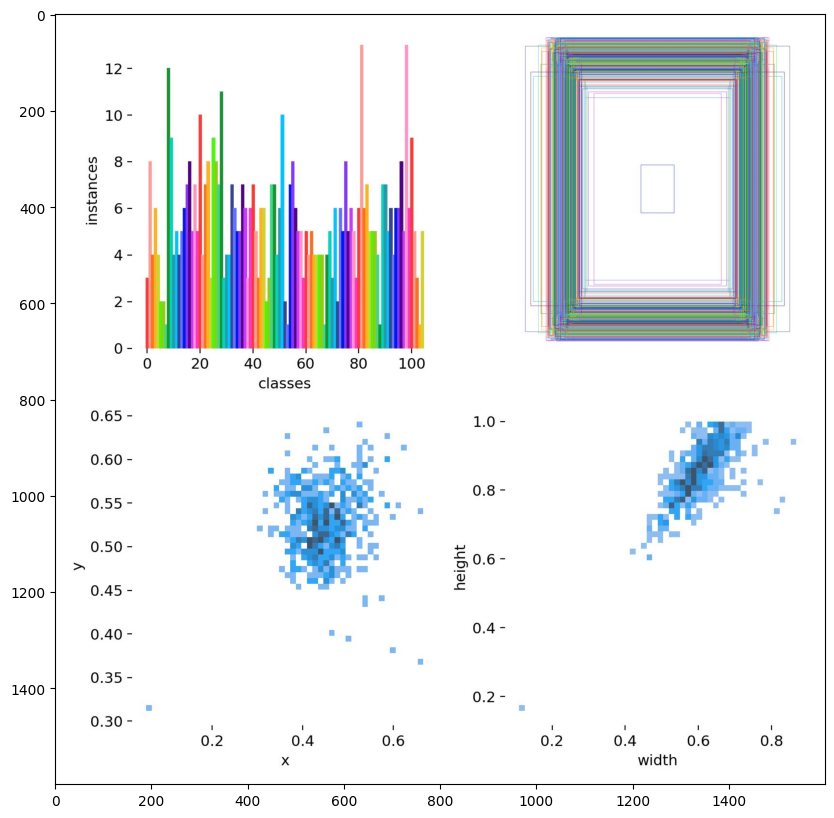

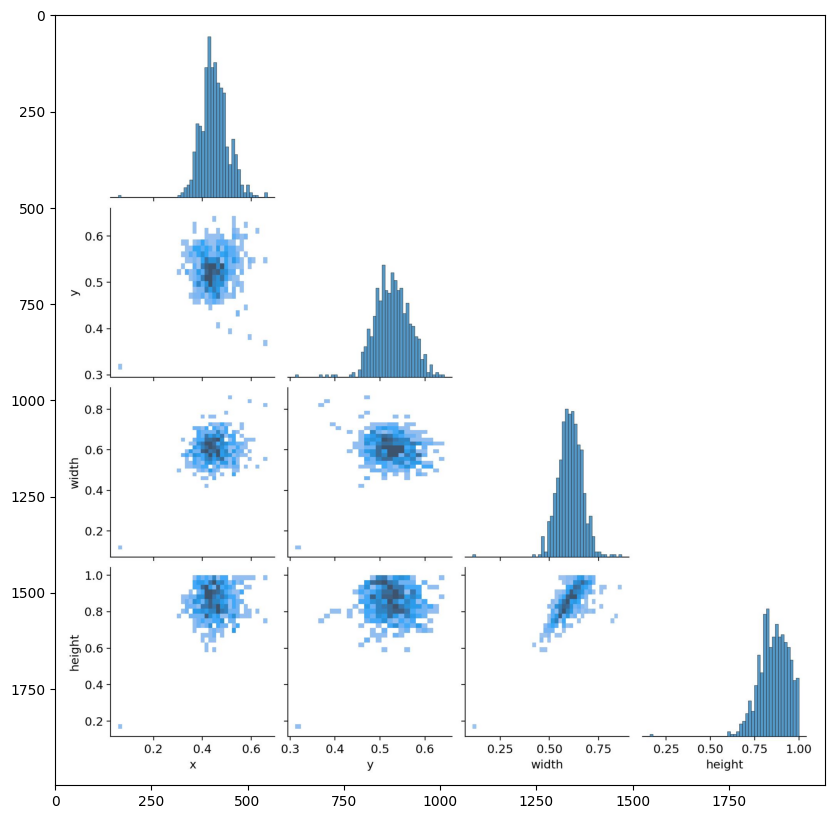

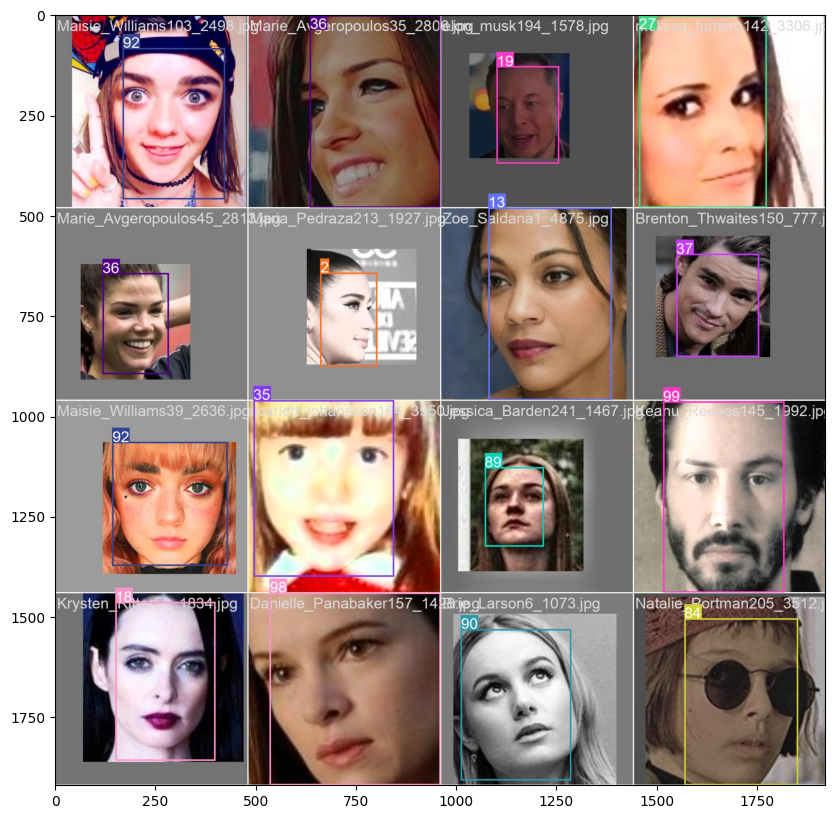

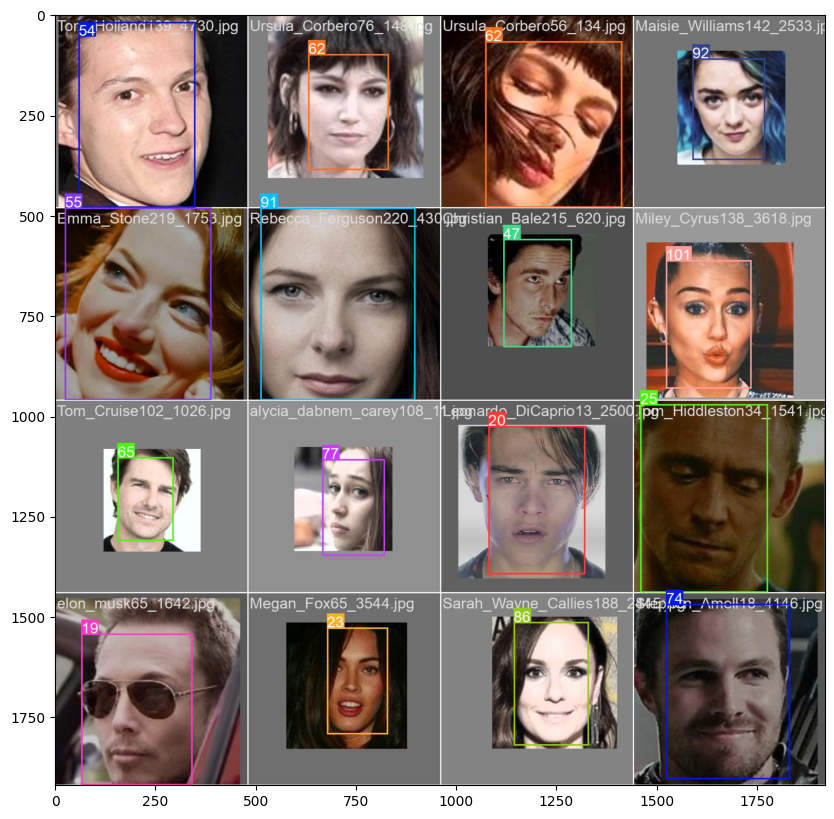

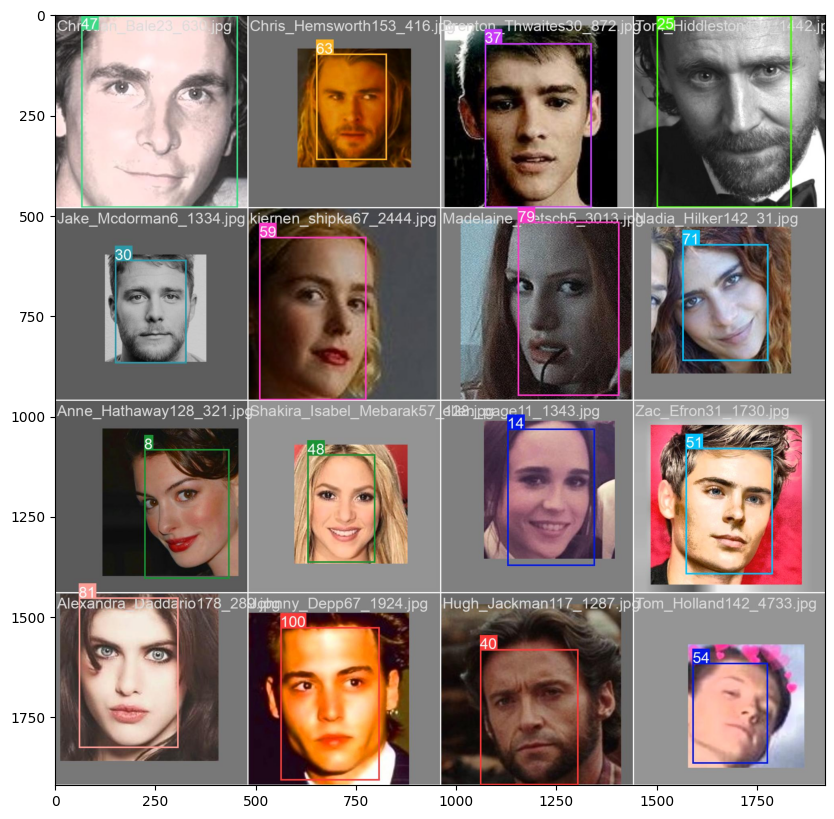

In [32]:
for path in paths2:
    image = Image.open(path)
    image=np.array(image)
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    plt.show()

In [33]:
best_path0='runs/detect/train/weights/best.pt'
source0='datasets/test'

In [34]:
!ls runs/detect/train/

args.yaml					   train_batch0.jpg
events.out.tfevents.1696929867.ffbd01276c31.134.0  train_batch1.jpg
labels.jpg					   train_batch2.jpg
labels_correlogram.jpg				   weights


In [35]:
ppaths=[]
for dirname, _, filenames in os.walk(source0):
    for filename in filenames:
        if filename[-4:]=='.jpg':
            ppaths+=[(os.path.join(dirname, filename))]
ppaths=sorted(ppaths)
print(len(ppaths))

200


In [36]:
model2 = YOLO(best_path0)

FileNotFoundError: [Errno 2] No such file or directory: 'runs/detect/train/weights/best.pt'

In [ ]:
!yolo task=detect mode=predict model={best_path0} conf=0.1 source={source0}

# Result of Prediction

In [ ]:
results = model2.predict(source0,conf=0.1)
print(len(results))
print(len(ppaths))

In [ ]:
PBOX=pd.DataFrame(columns=range(6))
for i in range(len(results)):
    arri=pd.DataFrame(results[i].boxes.data.cpu().numpy()).astype(float)
    path=ppaths[i]
    file=path.split('/')[-1]
    arri=arri.assign(file=file)
    arri=arri.assign(i=i)
    PBOX=pd.concat([PBOX,arri],axis=0)
PBOX.columns=['x','y','x2','y2','confidence','class','file','i']
display(PBOX)

In [ ]:
PBOX['class']=PBOX['class'].apply(lambda x: reverse_mapping[int(x)])
PBOX=PBOX.reset_index(drop=True)
display(PBOX)
display(PBOX['class'].value_counts())

In [ ]:
for i in range(len(PBOX)):
    judged_name=PBOX.loc[i,'class'][5:].replace(' ','_')
    #print(judged_name)
    file=PBOX.loc[i,'file']
    if judged_name in file:
        PBOX.loc[i,'judge']=True
    else:
        PBOX.loc[i,'judge']=False
display(PBOX['judge'].value_counts())

In [ ]:
display(PBOX)

In [ ]:
def draw_box2(n0):
    
    ipath=ppaths[n0]
    image=cv2.imread(ipath)
    H,W=image.shape[0],image.shape[1]
    file=ipath.split('/')[-1]
    
    if PBOX[PBOX['file']==file] is not None:
        box=PBOX[PBOX['file']==file]
        box=box.reset_index(drop=True)
        #display(box)

        for i in range(len(box)):
            label=box.loc[i,'class']
            x=int(box.loc[i,'x'])
            y=int(box.loc[i,'y'])
            x2=int(box.loc[i,'x2']) 
            y2=int(box.loc[i,'y2'])
            #print(label,x,y,x2,y2)
            cv2.putText(image, f'{label}', (x, int(y-4)), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1.0, (255,0,0),2)
            cv2.rectangle(image,(x,y),(x2,y2),(255,0,0),1)

    #plt.imshow(image)
    #plt.show()   
    
    return image

In [ ]:
def create_animation(ims):
    fig=plt.figure(figsize=(12,8))
    im=plt.imshow(cv2.cvtColor(ims[0],cv2.COLOR_BGR2RGB))
    text = plt.text(0.05, 0.05, f'Slide {0}', transform=fig.transFigure, fontsize=14, color='blue')
    plt.axis('off')
    plt.close()

    def animate_func(i):
        im.set_array(cv2.cvtColor(ims[i],cv2.COLOR_BGR2RGB))
        text.set_text(f'Slide {i}')        
        return [im]    
    
    return animation.FuncAnimation(fig, animate_func, frames=len(ims), interval=1000//2)

In [ ]:
images2=[]
for i in tqdm(range(len(ppaths))):
    images2+=[draw_box2(i)]

In [ ]:
create_animation(images2)